# Satvision-TOA Reconstruction Plotting Notebook

# Pt 2/2

Version: 06.07.24

Env: `Python [conda env:ilab-pytorch]`

In [2]:
import os
import sys
import time
import joblib
import random
import datetime
from tqdm import tqdm
import numpy as np
import logging

import torch
import torch.cuda.amp as amp

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings

warnings.filterwarnings('ignore') 

In [3]:
sys.path.append('../../pytorch-caney')

from pytorch_caney.config import get_config

from pytorch_caney.models.build import build_model

from pytorch_caney.ptc_logging import create_logger

from pytorch_caney.data.datasets.mim_modis_22m_dataset import MODIS22MDataset

from pytorch_caney.data.transforms import SimmimTransform, SimmimMaskGenerator

from pytorch_caney.config import _C, _update_config_from_file

## 1. Configuration

In [12]:
# version strings used when generating data from satvision-toa-reconstruction-generation-scaled.ipynb

versionA = 'hugeDiscover-ep88-scaledDLscaledRSB1e-2' # Your new model version
versionB = 'giantDiscover26m-ep97' # Latest best of the un-scaled reflectance and k models

# Output version string
version = 'huge.88.huge.2m.scaled.radiance'

# Which bands
bands = range(0, 14)
band = 'All'

In [5]:
recon_path_a = f'recons128.v{versionA}.cAll.sav'
diff_path_a = f'diffs128.v{versionA}.cAll.sav'

recon_path_b = f'recons128.v{versionB}.cAll.sav'
diff_path_b = f'diffs128.v{versionB}.cAll.sav'

In [6]:
diff_as = np.array(joblib.load(diff_path_a)[:])
recon_as = np.array(joblib.load(recon_path_a)[:])

In [7]:
diff_bs = np.array(joblib.load(diff_path_b)[:])
recon_bs = np.array(joblib.load(recon_path_b)[:])

## 6. Plot and write to PDF

Writes out all of the predictions to a PDF file

In [8]:
plt.rcParams.update({'font.size': 22})

idx_to_band = {
    0: 1, # Ref 250m
    1: 2, # Ref 250m
    2: 3, # Ref 500m
    3: 6, # Ref 500m
    4: 7, # Ref 500m
    5: 21, # Emi 1km
    6: 26, # Ref 1km
    7: 27, # Emi 1km
    8: 28, # Emi 1km
    9: 29, # Emi 1km
    10: 30, # Emi 1km
    11: 31, # Emi 1km
    12: 32, # Emi 1km
    13: 33 # Emi 1km
}

idx_to_wavelength = {
    0: '0.659 um',  # ABI 2
    1: '0.865 um',  # ABI 3
    2: '0.47 um',   # ABI 1
    3: '1.64 um',   # ABI 5
    4: '2.13 um',   # ABI 6
    5: '3.96 um',   # ABI 7
    6: '1.375 um',  # ABI 4
    7: '6.72 um',   # ABI 9 (or 8)
    8: '7.33 um',   # ABI 10
    9: '8.55 um',   # ABI 11
    10: '9.73 um',  # ABI 12
    11: '11.03 um', # ABI 14
    12: '12.20 um', # ABI 15
    13: '13.34 um', # ABI 16
}

reflectance_bands = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,26]
emissive_bands = [20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36]

In [9]:
def plot_show(path, diffs_a, recons_a, diffs_b, recons_b, band, crop=0):
    pdf_plot_obj = PdfPages(path)
    resize_to_128_crop = 0
    aC = crop // 2 # Additional crop, total crop for 128s
    cN = resize_to_128_crop + aC # Total crop for 192s
    print(f'Cropping each size by {cN} pixels')

    # ---
    # Ranges, calculated globally
    # diff range
    # ---
    if cN > 0:
        diffs_a_perBand = diffs_a[:, band, aC:-aC, aC:-aC]
        diffs_b_perBand = diffs_b[:, band, cN:-cN, cN:-cN] # Clip to size
        recons_a_perBand = recons_a[:, band, aC:-aC, aC:-aC]
        recons_b_perBand = recons_b[:, band, cN:-cN, cN:-cN] # Clip to size
    else:
        diffs_a_perBand = diffs_a[:, band]
        diffs_b_perBand = diffs_b[:, band] # Clip to size
        recons_a_perBand = recons_a[:, band]
        recons_b_perBand = recons_b[:, band] # Clip to size

    assert len(diffs_a_perBand.shape) == 3
    assert len(diffs_b_perBand.shape) == 3
    diff_vmax_a = np.nanmax(diffs_a_perBand)
    diff_vmin_a = -diff_vmax_a # We want an even range for the diff map. 0 should be white
    diff_vmax_b = np.nanmax(diffs_b_perBand)
    diff_vmin_b = -diff_vmax_b

    print(f'Diff Range A: ({diff_vmin_a}, {diff_vmax_a})')
    print(f'Diff Range B: ({diff_vmin_b}, {diff_vmax_b})')

    # reconstruction range
    assert len(recons_a_perBand.shape) == 3
    assert len(recons_b_perBand.shape) == 3
    assert recons_a_perBand.shape == diffs_a_perBand.shape
    assert recons_b_perBand.shape == diffs_b_perBand.shape
    # recon_vmin_a = np.nanmin(recons_a_perBand) # min(np.nanmin(recons_a_perBand), np.nanmin(recons_b_perBand))
    # recon_vmax_a = np.nanmax(recons_a_perBand) # max(np.nanmax(recons_a_perBand), np.nanmax(recons_b_perBand))
    # print(f'Recon Range A: ({recon_vmin_a}, {recon_vmax_a})')
    # print(f'Recon Range B: ({recon_vmin_b}, {recon_vmax_b})')
    
    channel = idx_to_band[band]
    channel_wl = idx_to_wavelength[band]
    processed_type = 'Reflectance' if channel in reflectance_bands else 'Brightness Temp (K)'
    radiance_units = 'W/m^2/μm/sr'
    print(f'Visualizing reconstruction for band {channel} ({channel_wl})')


    for idx in range(recons_a_perBand.shape[0]):
        
        # prediction processing
        diff_a = diffs_a_perBand[idx]
        diff_b = diffs_b_perBand[idx]
        recon_a = recons_a_perBand[idx]
        recon_b = recons_b_perBand[idx]

        fig, axs = plt.subplots(3, 2, figsize=(30, 30))

        # ---
        # First row: imshow plots
        # Reconstruction images
        # vmin and vmax are ranged per-image not per-batch if these lines are uncommented
        recon_vmin_a = np.nanmin(recon_a)
        recon_vmax_a = np.nanmax(recon_a)
        recon_vmin_b = np.nanmin(recon_b)
        recon_vmax_b = np.nanmax(recon_b)
        # ---
    
        recon_plot_a = axs[0, 0].matshow(recon_a, vmin=recon_vmin_a, vmax=recon_vmax_a, ) # cmap='Greys_r')
        axs[0, 0].set_title(f"Idx: {idx} Model A reconstruction, Band: {channel} ({channel_wl}) {radiance_units}")
        recon_plot_b = axs[0, 1].matshow(recon_b, vmin=recon_vmin_b, vmax=recon_vmax_b, ) # cmap='Greys_r')
        axs[0, 1].set_title(f"Idx: {idx} Model B reconstruction, Band: {channel} ({channel_wl}) {processed_type}")
        cbar_ax = fig.add_axes([0.45, 0.7, 0.02, 0.2])  # [left, bottom, width, height]
        fig.colorbar(recon_plot_a, cax=cbar_ax, orientation='vertical', fraction=1)
        cbar_ax = fig.add_axes([0.95, 0.7, 0.02, 0.2])  # [left, bottom, width, height]
        fig.colorbar(recon_plot_b, cax=cbar_ax, orientation='vertical', fraction=1)

        # ---
        # Second row: matshow plots with shared colorbar
        # Diff per-channel
        # norm = plt.Normalize(-100, 100)
        # vmin = min(np.nanmin(diff_128), np.nanmin(diff_192))
        # vmax = max(np.nanmax(diff_128), np.nanmax(diff_192))
        # ---
        diff_plot_a = axs[1, 0].matshow(diff_a, cmap='seismic', vmin=diff_vmin_a, vmax=diff_vmax_a)
        axs[1, 0].set_title(f"Diff Heatmap, + reconstruction, - ground truth image")
        diff_plot_b = axs[1, 1].matshow(diff_b, cmap='seismic', vmin=diff_vmin_b, vmax=diff_vmax_b)
        axs[1, 1].set_title(f"+ reconstruction / - ground truth image")

        # Create a colorbar for matshow plots
        cbar_ax = fig.add_axes([0.45, 0.4, 0.02, 0.2])  # [left, bottom, width, height]
        fig.colorbar(diff_plot_a, cax=cbar_ax, orientation='vertical', fraction=1)
        cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.2])  # [left, bottom, width, height]
        fig.colorbar(diff_plot_b, cax=cbar_ax, orientation='vertical', fraction=1)

        # ---
        # Third row: histograms with shared y-axis
        # Left histogram
        # N bins == 64, optimal?
        # ---
        nbins = 64
        hist_range_a = (diff_vmin_a, diff_vmax_a)
        hist_range_b = (diff_vmin_b, diff_vmax_b)
        mean_a = np.nanmean(diff_a)
        std_a = np.nanstd(diff_a)
        mean_b = np.nanmean(diff_b)
        std_b = np.nanstd(diff_b)
        
        # Model A histogram
        axs[2, 0].hist(diff_a.flatten(), bins=nbins, alpha=0.7, color='blue', range=hist_range_a)

        axs[2, 0].text(0.95, 0.95, f'Mean: {mean_a:.2f}',
                       horizontalalignment='right', verticalalignment='top',
                       transform=axs[2, 0].transAxes, color='blue', fontsize=16)

        axs[2, 0].text(0.95, 0.90, f'Std: {std_a:.2f}',
                       horizontalalignment='right', verticalalignment='top',
                       transform=axs[2, 0].transAxes, color='blue', fontsize=16)

        axs[2, 0].set_title(f"Diff Histogram")

        # Model B histogram
        axs[2, 1].hist(diff_b.flatten(), bins=nbins, alpha=0.7, color='green', range=hist_range_b)

        axs[2, 1].text(0.95, 0.95, f'Mean: {mean_b:.2f}',
                       horizontalalignment='right', verticalalignment='top',
                       transform=axs[2, 1].transAxes, color='green', fontsize=16)

        axs[2, 1].text(0.95, 0.90, f'Std: {std_b:.2f}',
                       horizontalalignment='right', verticalalignment='top',
                       transform=axs[2, 1].transAxes, color='green', fontsize=16)

        axs[2, 1].set_title(f"+ reconstruction / - ground truth image")

        # Shared axis, does this do anything?
        # axs[2, 0].get_shared_y_axes().join(axs[2, 0], axs[2, 1])
        axs[2, 0].set_ylabel('Frequency')

        # Adjust layout for better spacing
        plt.tight_layout()
        pdf_plot_obj.savefig()
    
    pdf_plot_obj.close()

Cropping each size by 0 pixels
Diff Range A: (-2.831550121307373, 2.831550121307373)
Diff Range B: (-67.75938415527344, 67.75938415527344)
Visualizing reconstruction for band 32 (12.20 um)


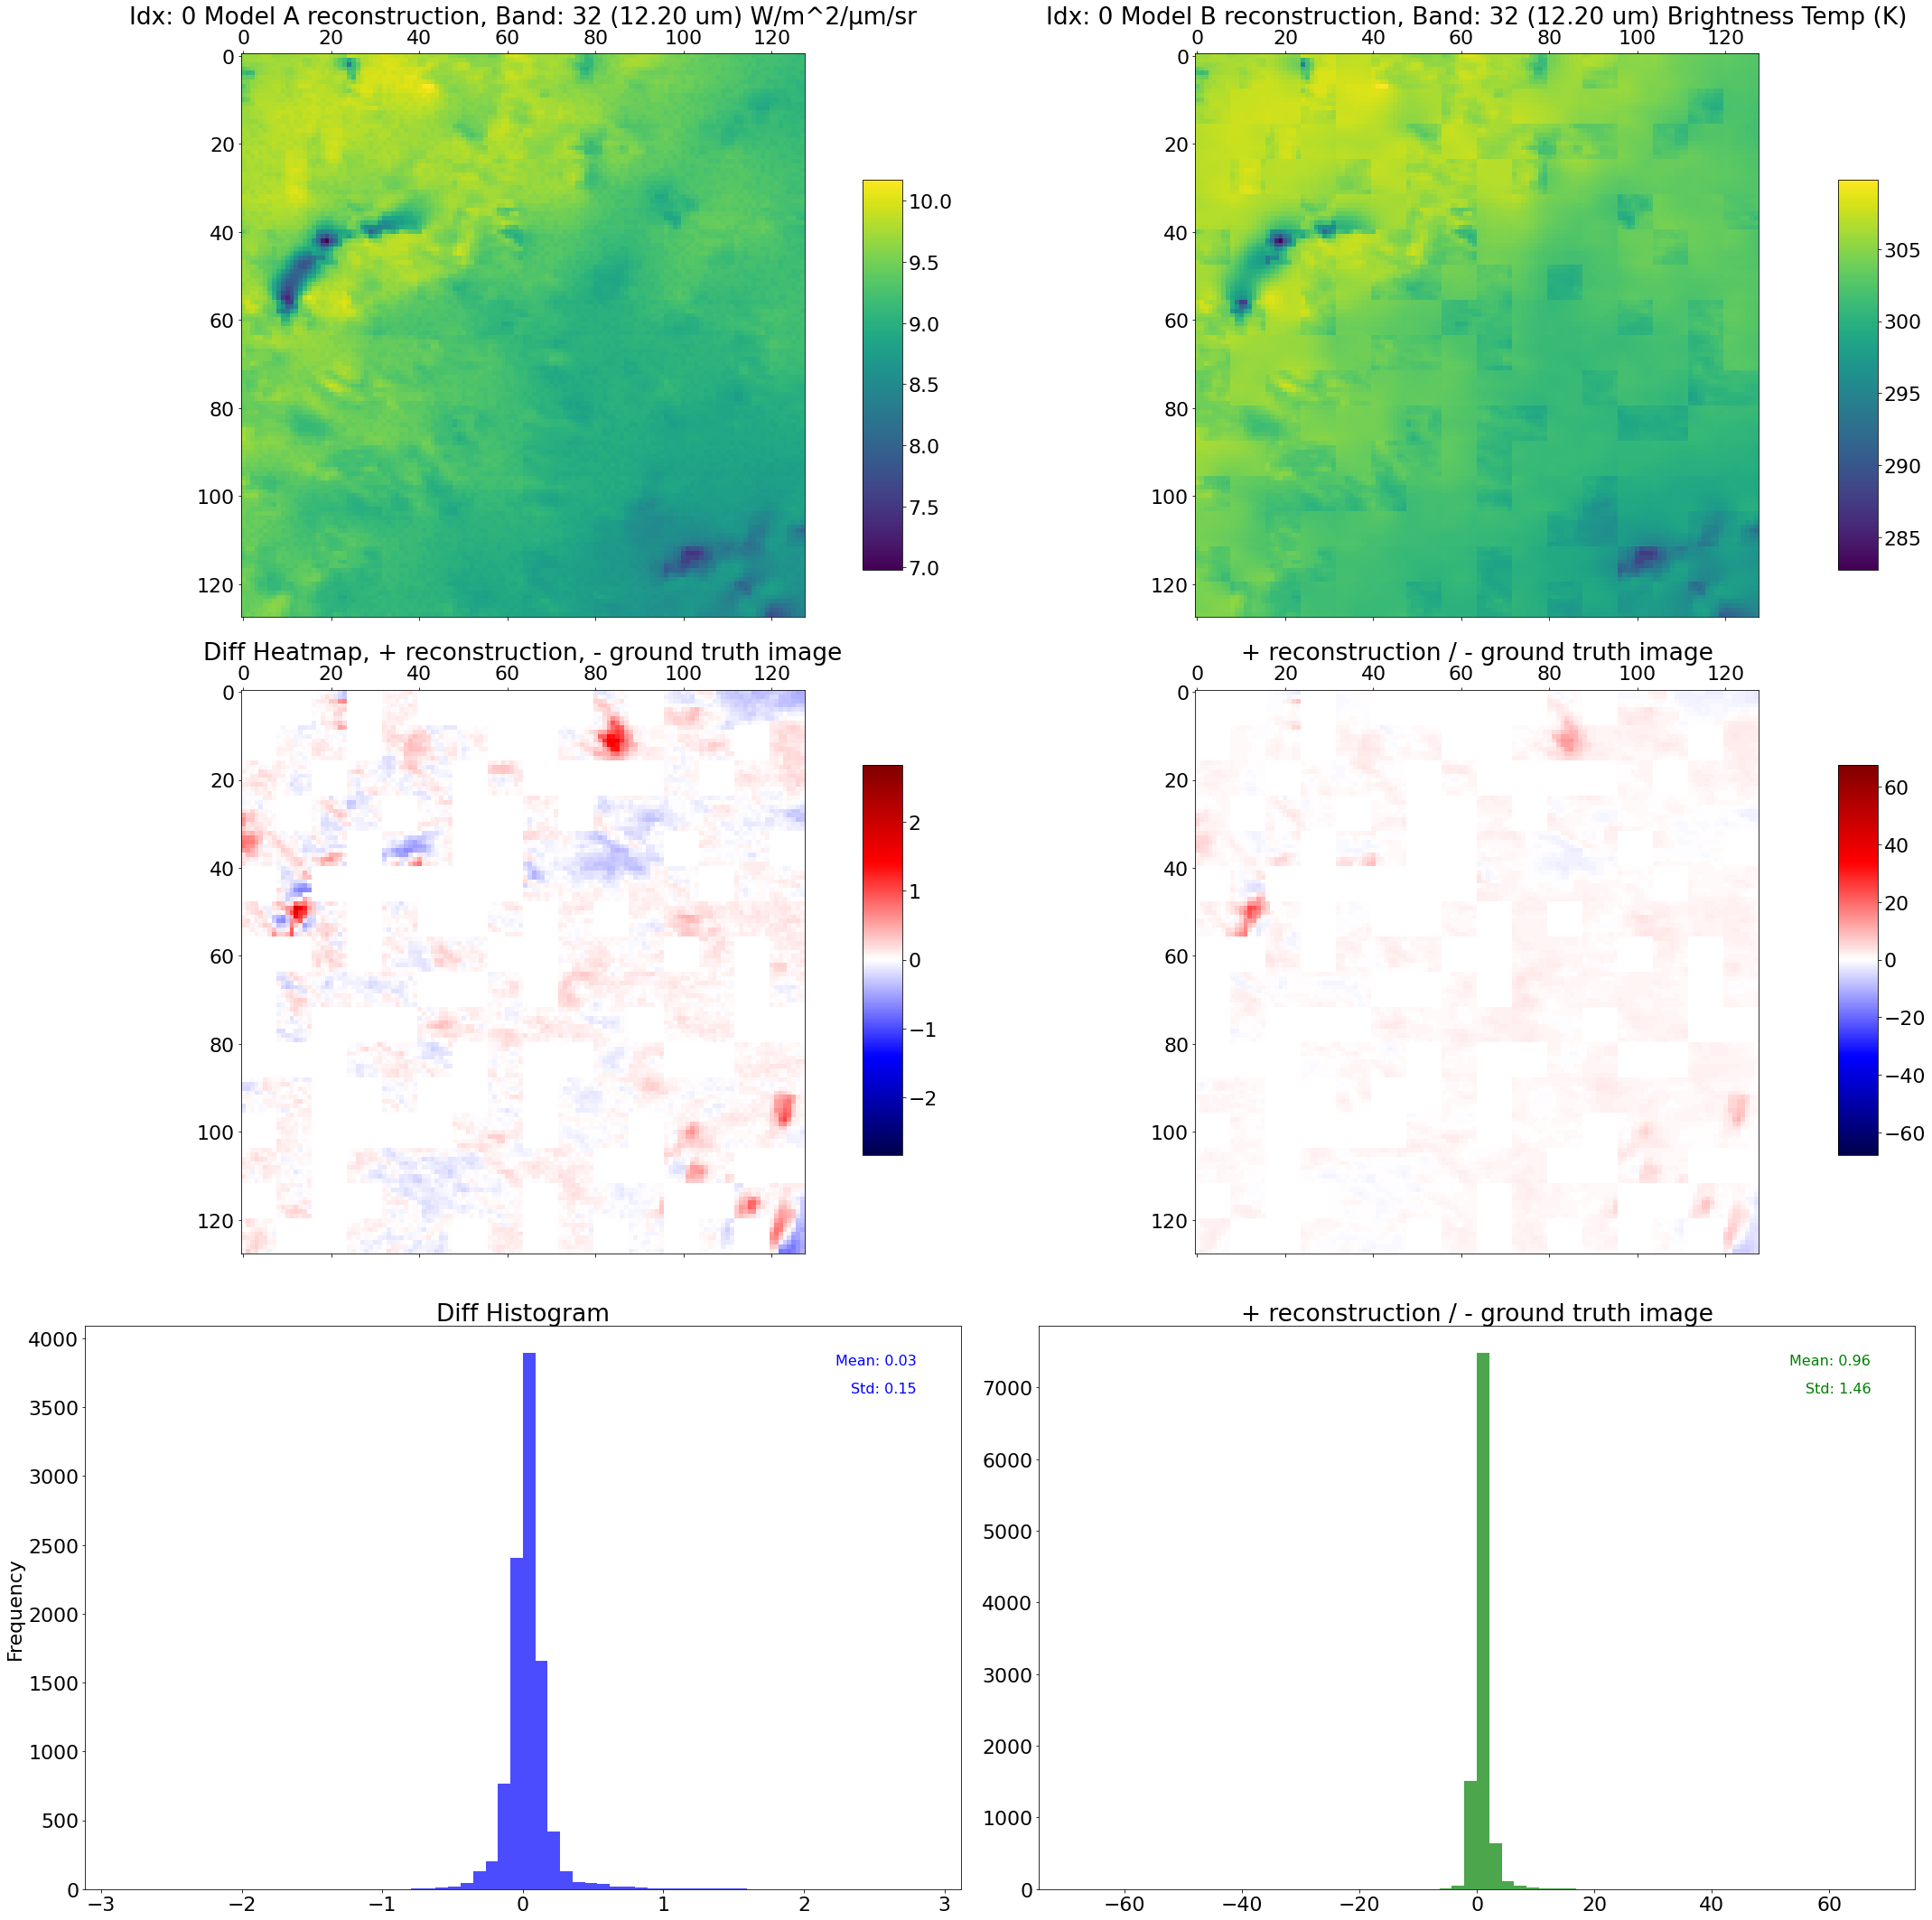

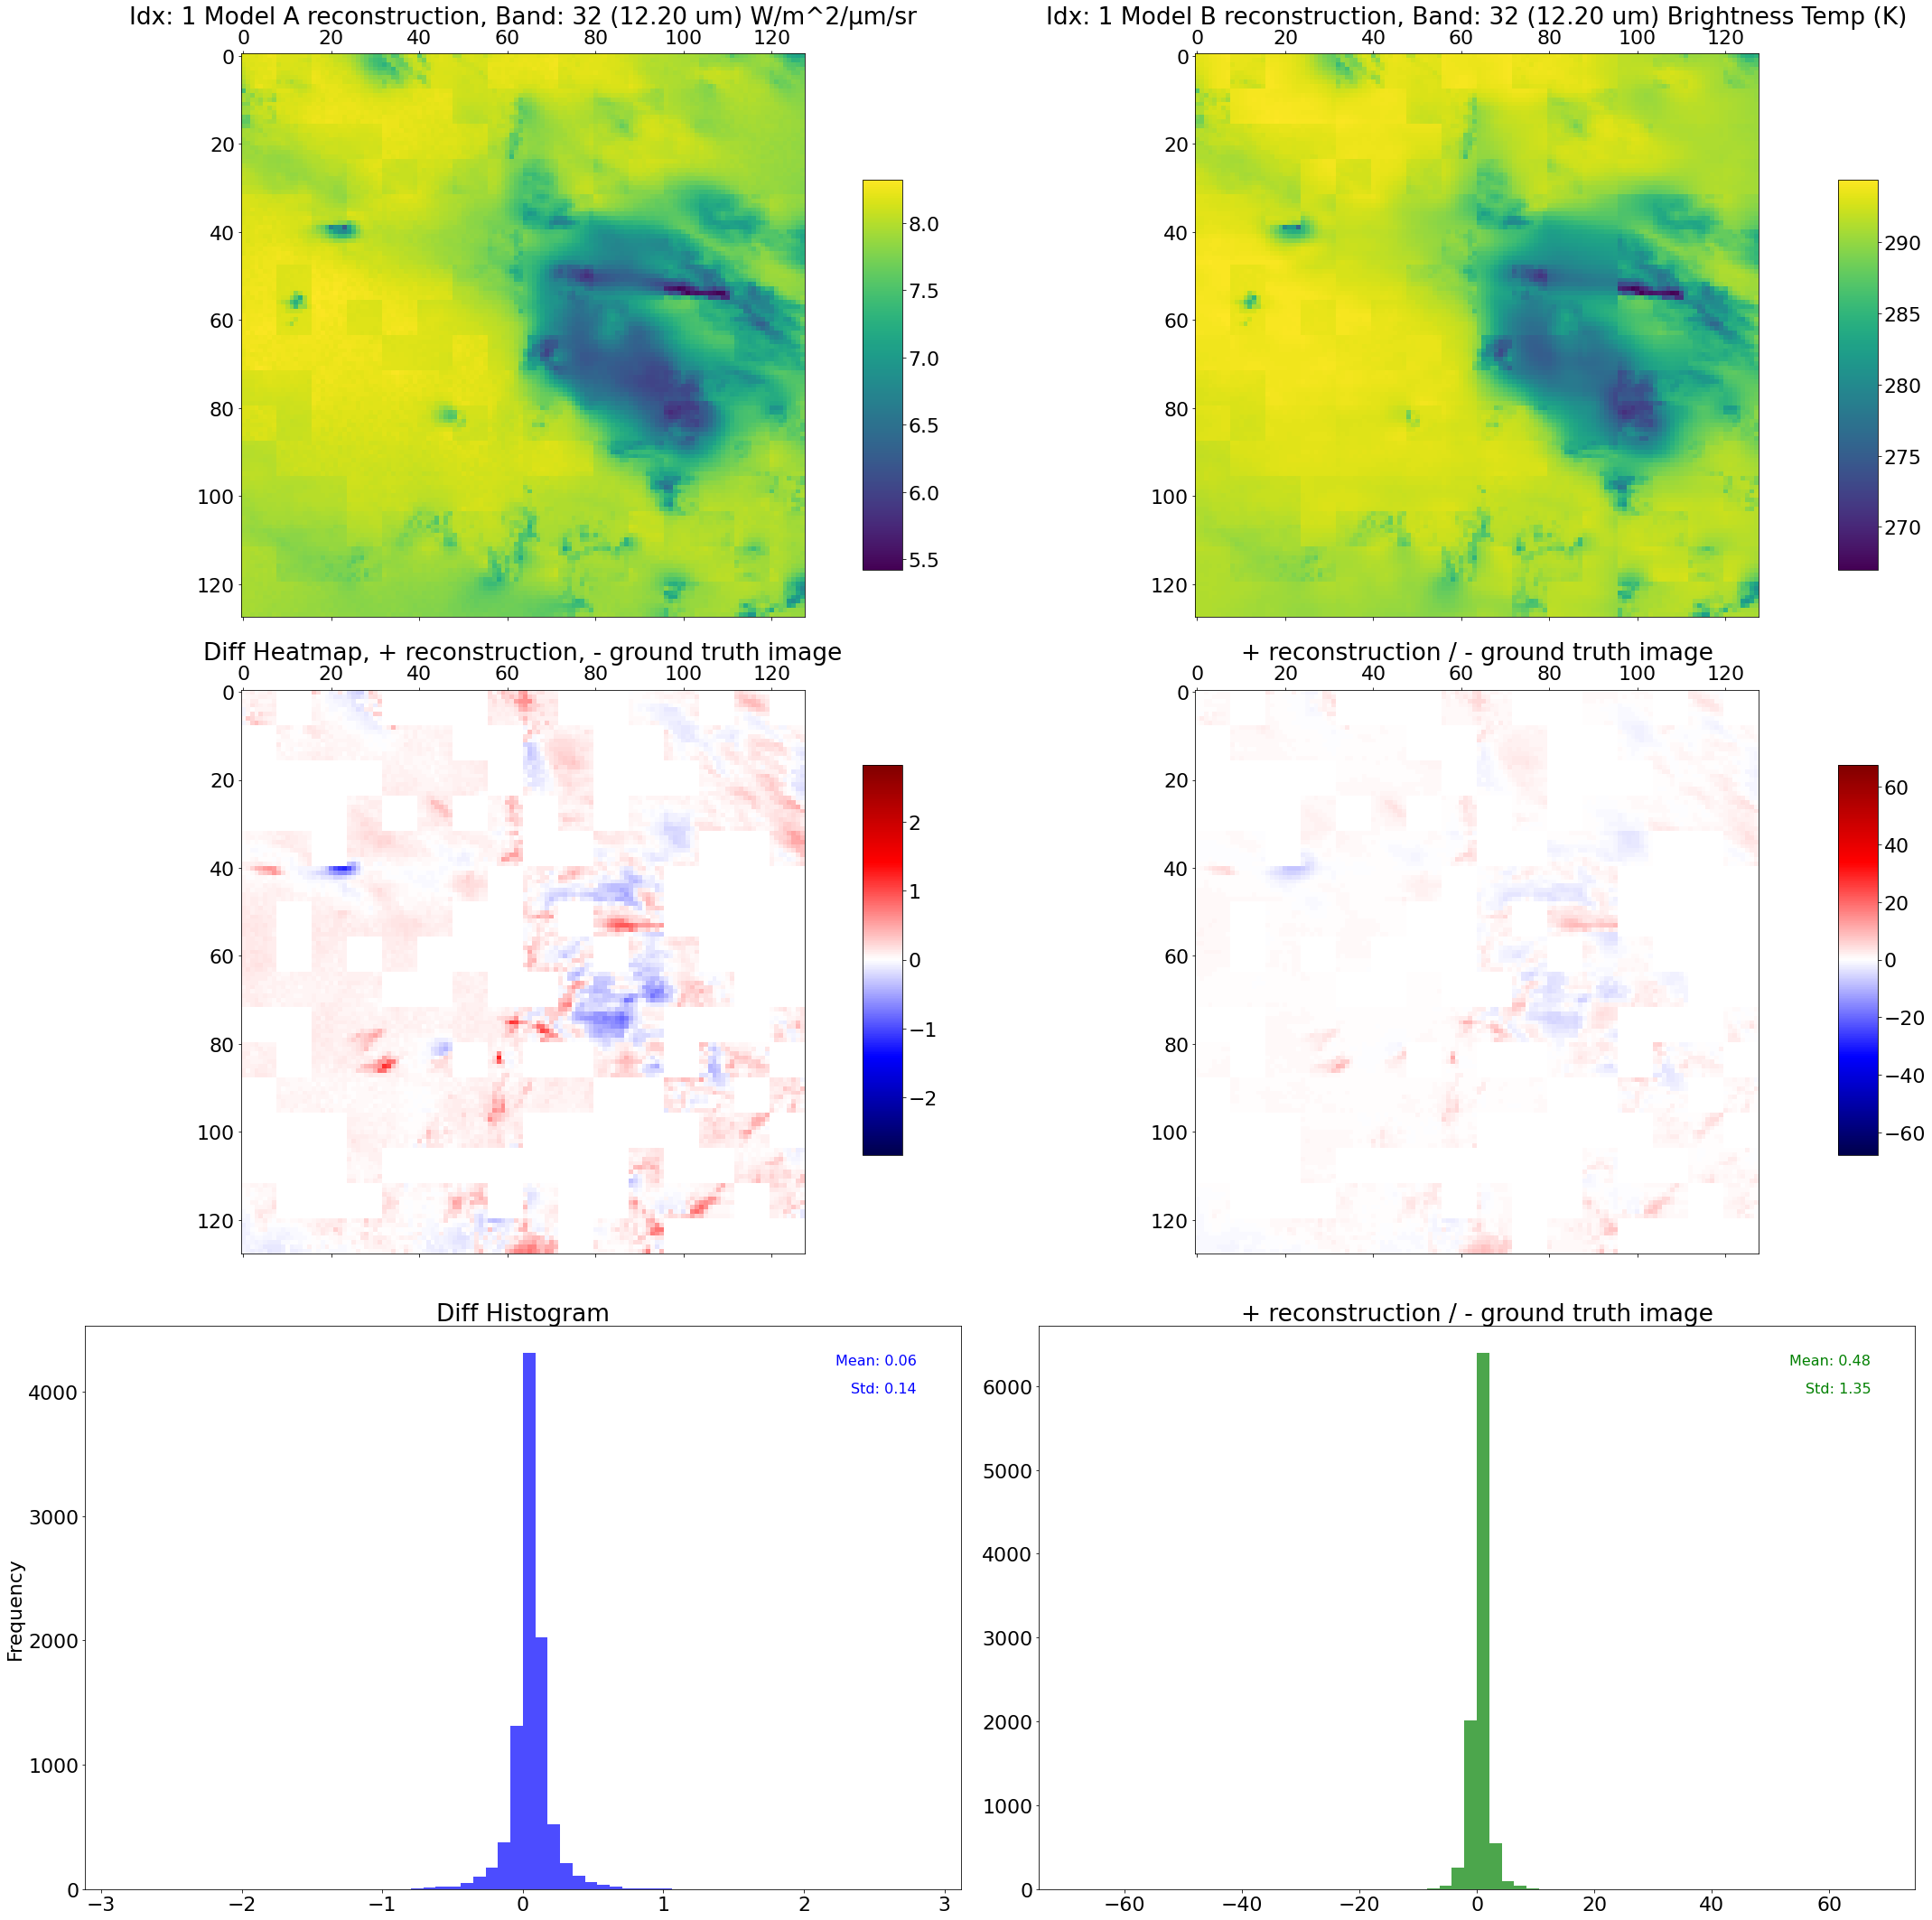

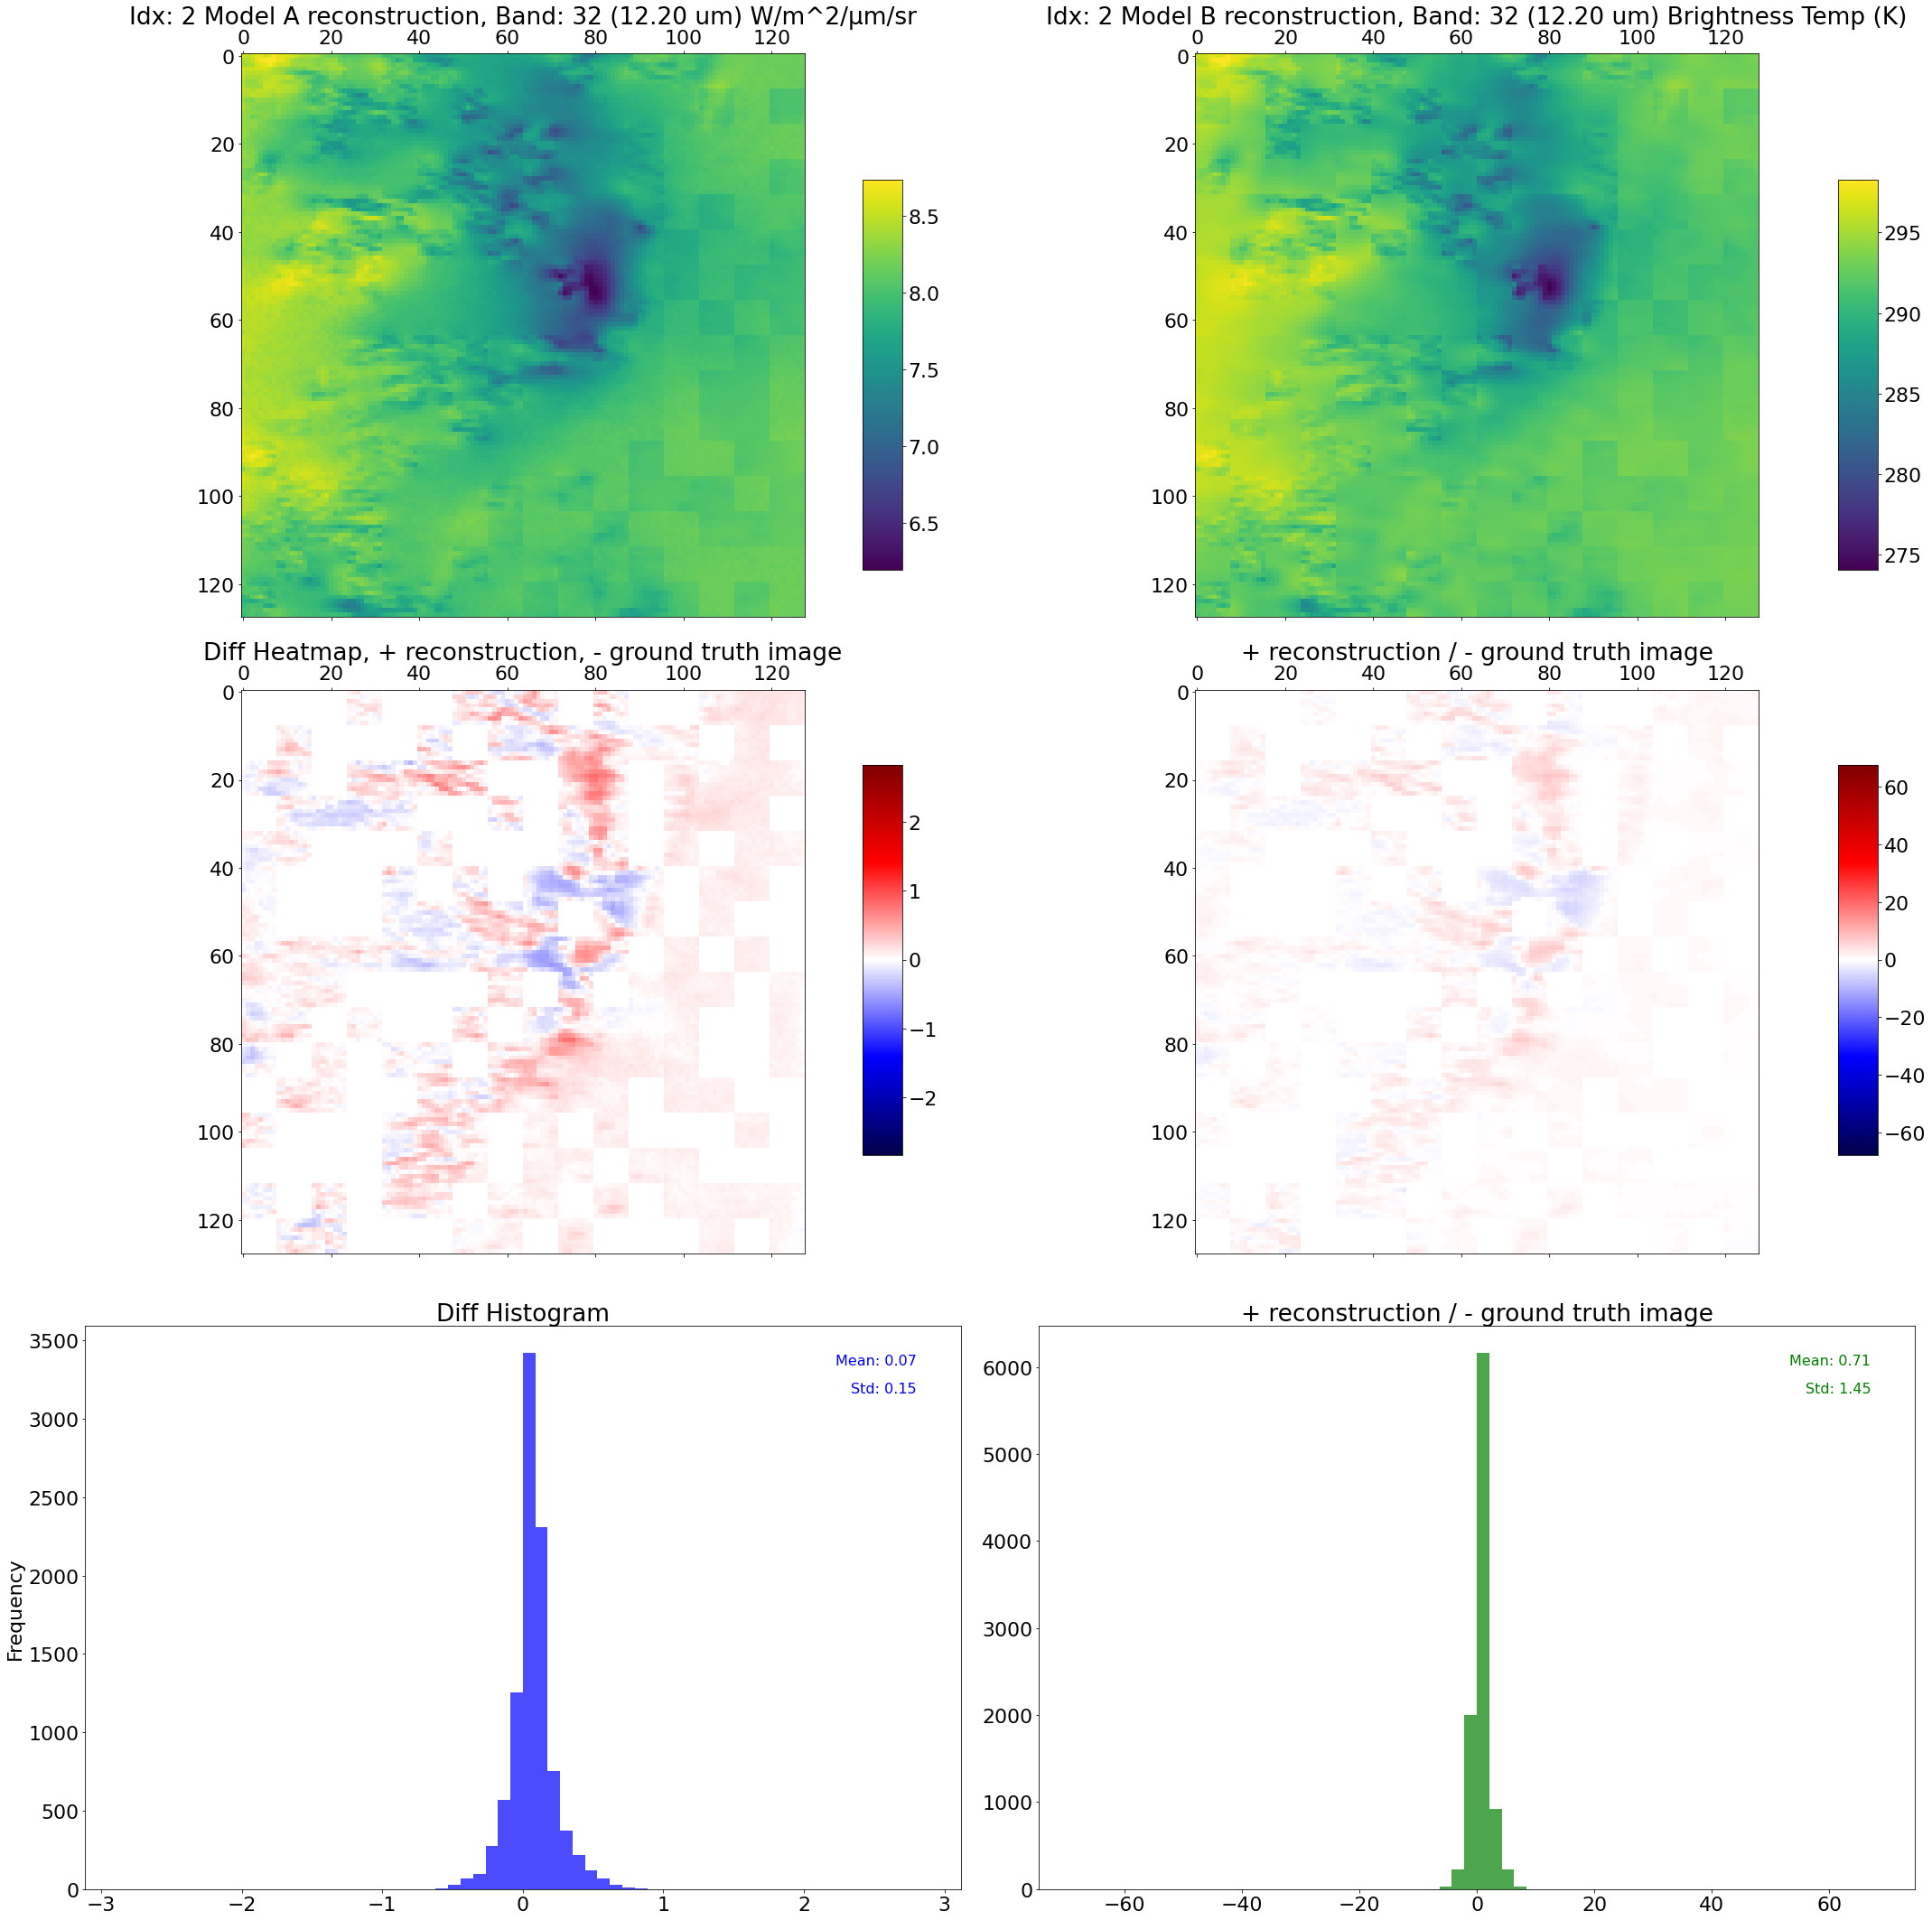

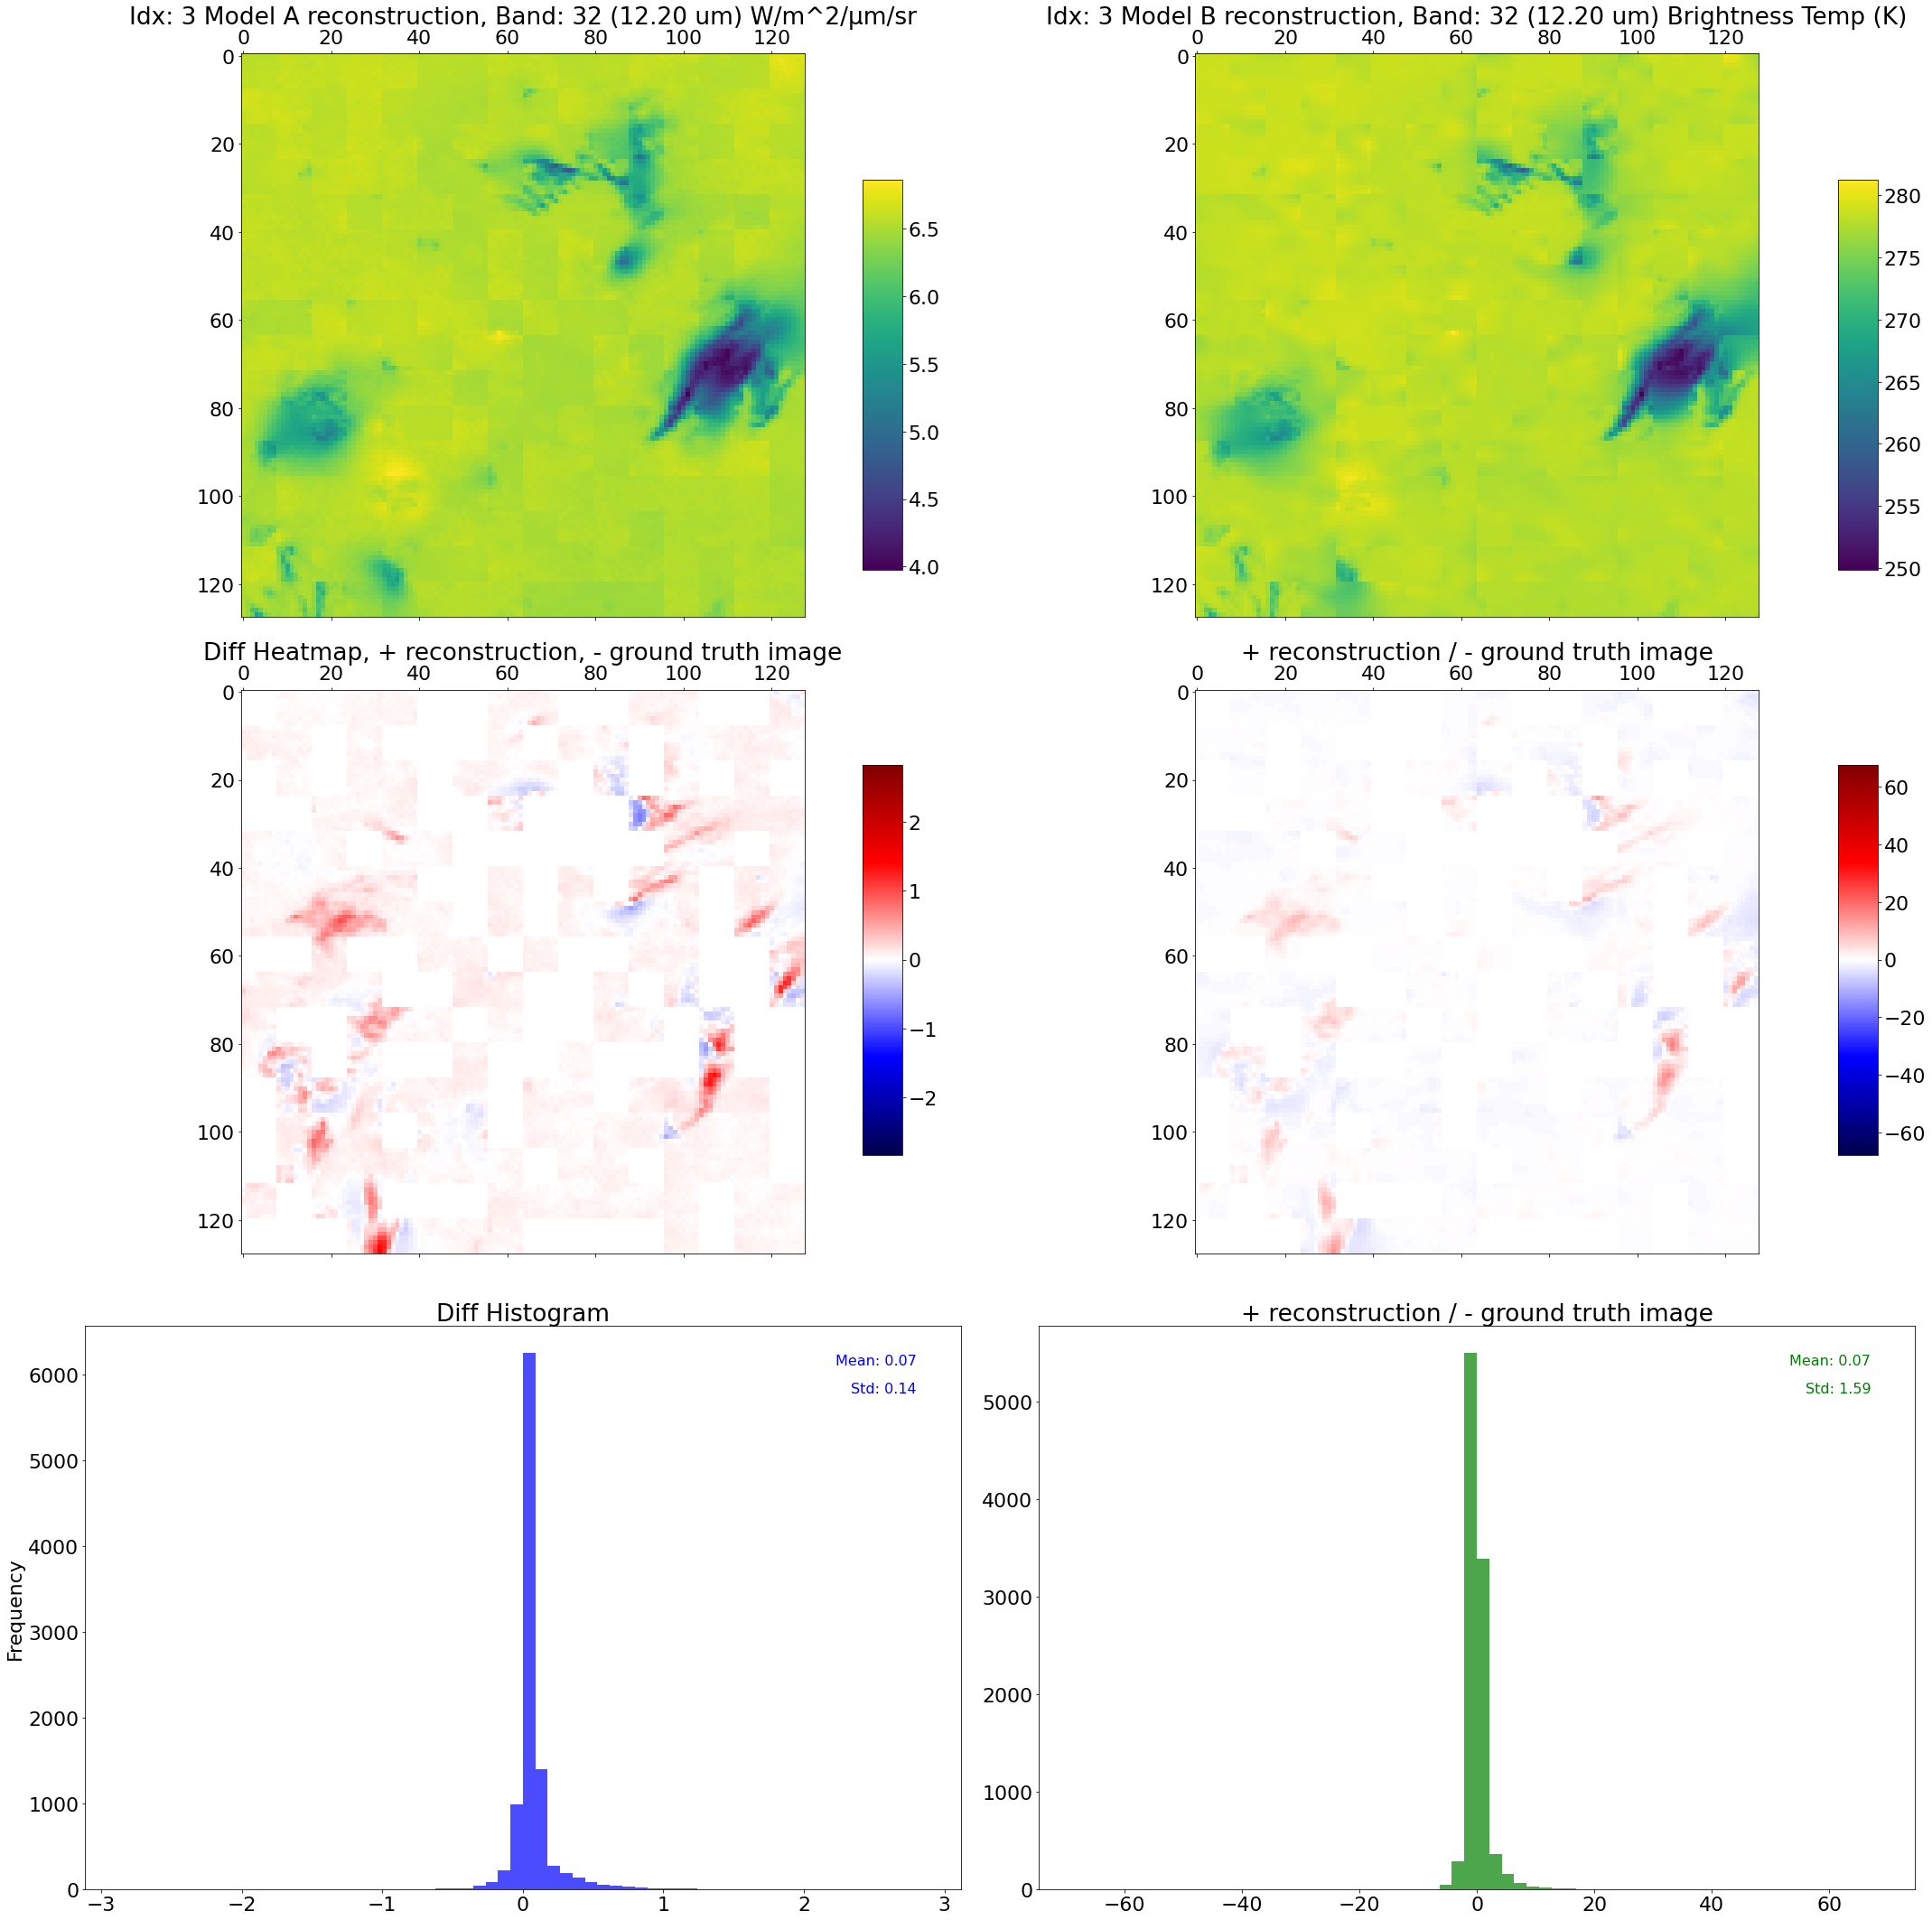

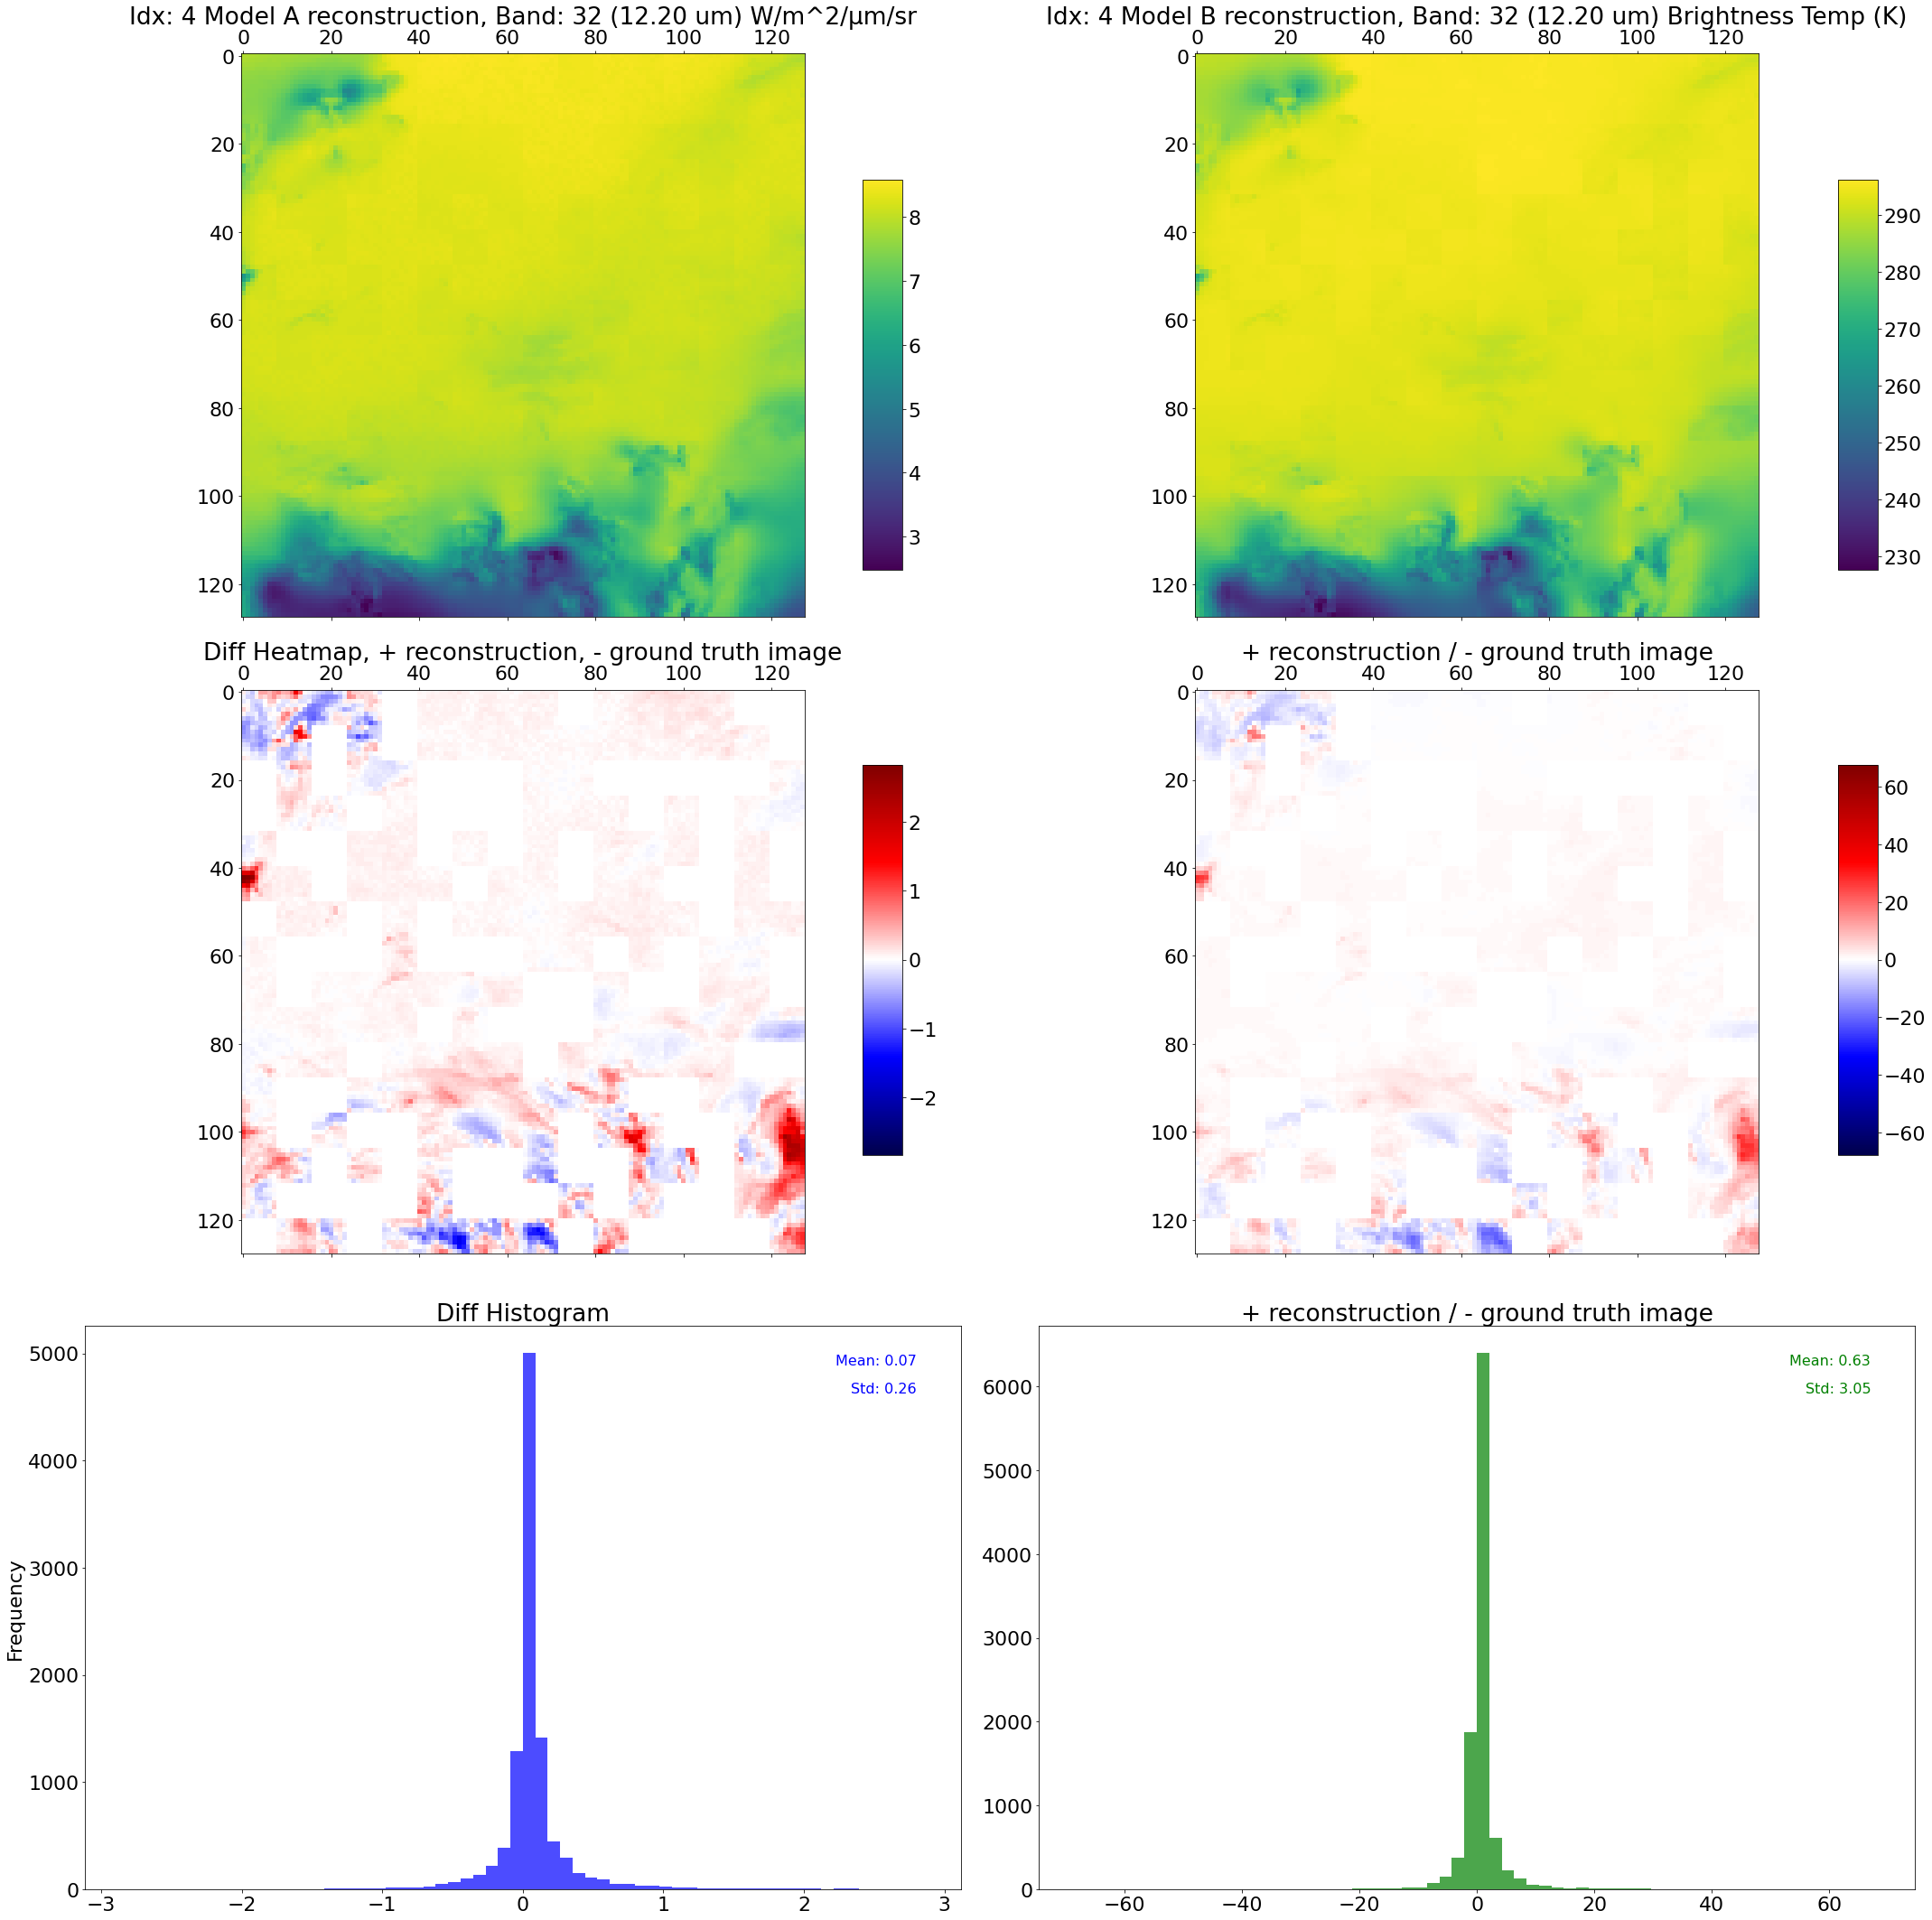

In [10]:
# Test with a small subset on band
band = 12
pdf_path = f'satvision-toa-reconstruction-pdf-scale-patch-8-compare-06.06.full.v{version}.channel0.pdf'
plot_show(pdf_path, diff_as[:5], recon_as[:5], diff_bs, recon_bs, band)

In [ ]:
# Plot all the bands in individual PDFs

for band in bands:
    pdf_path = f'satvision-toa-reconstruction-pdf-scale-rsb-scale-1e-2-patch-8-compare-06.06.full.v{version}.channel{band}.pdf'
    plot_show(pdf_path, diff_as, recon_as, diff_bs, recon_bs, band)

Cropping each size by 0 pixels
Diff Range A: (-2.384681224822998, 2.384681224822998)
Diff Range B: (-47.9204216003418, 47.9204216003418)
Visualizing reconstruction for band 1 (0.659 um)
Cropping each size by 0 pixels
Diff Range A: (-1.5874985456466675, 1.5874985456466675)
Diff Range B: (-49.93202590942383, 49.93202590942383)
Visualizing reconstruction for band 2 (0.865 um)
Cropping each size by 0 pixels
Diff Range A: (-3.0454976558685303, 3.0454976558685303)
Diff Range B: (-46.732398986816406, 46.732398986816406)
Visualizing reconstruction for band 3 (0.47 um)
Cropping each size by 0 pixels
Diff Range A: (-0.31507667899131775, 0.31507667899131775)
Diff Range B: (-35.87236785888672, 35.87236785888672)
Visualizing reconstruction for band 6 (1.64 um)
Cropping each size by 0 pixels
Diff Range A: (-0.1067577600479126, 0.1067577600479126)
Diff Range B: (-27.826475143432617, 27.826475143432617)
Visualizing reconstruction for band 7 (2.13 um)
Cropping each size by 0 pixels
Diff Range A: (-1.30